## Introduction

**Objective:**
The lab's objective is to utilize the wavenumber-domain operations for processing potential-field data, specifically on a planar observation surface. This involves converting various components of the data and implementing upward continuation techniques. The focus is on understanding and applying the theory behind these transformations in practical scenarios.

**Concepts Covered:**
- Wavenumber-Domain Operations: Understanding the use of wavenumber-domain (Fourier space) methods in geophysical data processing, particularly for potential-field data.
- Data Conversion and Upward Continuation: Techniques for converting different components of potential-field data and performing upward continuation at different heights.
- Transfer Functions in Wavenumber Domain: Exploration of how different components of potential-field data from the same source are interrelated through transfer functions in the wavenumber domain.
- Fourier Transform Techniques: Application of Fourier transforms (both forward and inverse) for the conversion and analysis of data.
- Comparative Analysis and Error Discussion: Comparing converted components with directly calculated ones to understand the accuracy and potential sources of error in the transformations.

## Problem Setup

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# access gravity tensor file
gravity_tensors = np.load('tensorfile.npz')

# set location arrays
northing = gravity_tensors['N']
easting = gravity_tensors['E']
height = gravity_tensors['H']

# set gravity tensor arrays
gtxx = gravity_tensors['Txx']
gtxy = gravity_tensors['Txy']
gtxz = gravity_tensors['Txz']
gtyy = gravity_tensors['Tyy']
gtyz = gravity_tensors['Tyz']
gtzz = gravity_tensors['Tzz']


# access new gravity tensor file
tensors_up = np.load('tensorfile_z100.npz')

# set tensor arrays
txx_up = tensors_up['Txx']
txy_up = tensors_up['Txy']
txz_up = tensors_up['Txz']
tyy_up = tensors_up['Tyy']
tyz_up = tensors_up['Tyz']
tzz_up = tensors_up['Tzz']

In [3]:
# access magnetic tensor file
magnetic_tensors = np.load('magnetic_anomaly.npz')

bax = magnetic_tensors['Bax']
bay = magnetic_tensors['Bay']
baz = magnetic_tensors['Baz']

# access total magnetic anomaly file
total_anomaly = np.load('total_magnetic_anomaly.npz')

bT = total_anomaly['dT']

## Define Functions

In [4]:
def calculate_wavenumbers(M, N, delta_x, delta_y):
    kx = M // 2
    ky = N // 2

    wavenumbers_x = [m * (2 * np.pi) / (M * delta_x) for m in range(-kx + 1, kx + 1)]
    wavenumbers_y = [n * (2 * np.pi) / (N * delta_y) for n in range(-ky + 1, ky + 1)]
    
    return np.array(wavenumbers_x), np.array(wavenumbers_y)

In [5]:
def fold_data(data):

    folded_data = np.zeros((64,64),dtype=np.complex_)   
    folded_data[33:,33:] = data[0:31,0:31]
    folded_data[0:33,0:33] = data[31:,31:]
    folded_data[0:33,33:] = data[31:,0:31]
    folded_data[33:,0:33] = data[0:31,31:]
    
    return folded_data

In [6]:
def unfold_data(transformed_data):

    unfolded_data = np.zeros((64,64),dtype=np.complex_)
    unfolded_data[0:31,0:31] = transformed_data[33:,33:]
    unfolded_data[31:,31:] = transformed_data[0:33,0:33]
    unfolded_data[31:,0:31] = transformed_data[0:33,33:]
    unfolded_data[0:31,31:] = transformed_data[33:,0:33]

    return unfolded_data

In [7]:
# define plotting function for tensors
def gravplot(T,title):
    plt.contourf(northing, easting,T, cmap='jet')
    plt.colorbar(label='Eotvos (10^-9/s^2)')
    plt.title(title)
    plt.xlabel('Northing (m)')
    plt.ylabel('Easting (m)')

In [8]:
# define plotting function for tensors
def magplot(T,title):
    plt.contourf(northing, easting,T, cmap='jet')
    plt.colorbar(label='nT')
    plt.title(title)
    plt.xlabel('Northing (m)')
    plt.ylabel('Easting (m)')

In [9]:
def make_real(fourier):
    fold_fourier = fold_data(fourier)
    
    inv_fourier = np.fft.ifft2(fold_fourier)
    
    new = unfold_data(inv_fourier)
    
    return new

## Task 1

### Q1

\begin{equation*}
\begin{aligned}
T_{xx} & \Rightarrow -\omega_x^2 \frac{\mathcal{F}(T_{zz})}{\omega_r^2} \\
T_{xy} & \Rightarrow -\omega_x \omega_y \frac{\mathcal{F}(T_{zz})}{\omega_r^2} \\
T_{xz} & \Rightarrow i \omega_x \frac{\mathcal{F}(T_{zz})}{\omega_r} \\
T_{yy} & \Rightarrow -\omega_y^2 \frac{\mathcal{F}(T_{zz})}{\omega_r^2} \\
T_{yz} & \Rightarrow i \omega_y \frac{\mathcal{F}(T_{zz})}{\omega_r}
\end{aligned}
\end{equation*}


In [10]:
def convert_grav(northing, easting, data, delta_x=25, delta_y=25):
    # get M and N from array
    M,N = np.shape(gtxx)
    
    # calculate wavenumbers
    wx_ar, wy_ar = calculate_wavenumbers(M, N, delta_x, delta_y)
    wx, wy = np.meshgrid(wx_ar,wy_ar, indexing='ij')
    wr = np.sqrt(wx**2+wy**2)
    wr[wr == 0] = 0.0001
    
    # fold input data
    folded = fold_data(data)
    
    # calculate 2d fft
    folded_fft = np.fft.fft2(folded)
    
    # unfold fft array
    unfolded_fft = unfold_data(folded_fft)
    
    # wavenumber operation
    Txx_w = -wx**2 * unfolded_fft / wr**2
    Txy_w = -wx * wy * unfolded_fft / wr**2
    Txz_w = 1j*wx * unfolded_fft / wr
    Tyy_w = -wy**2 * unfolded_fft / wr**2
    Tyz_w = 1j*wy * unfolded_fft / wr
    
    # bring back from frequency domain
    Txx_new = make_real(Txx_w)
    Txy_new = make_real(Txy_w)
    Txz_new = make_real(Txz_w)
    Tyy_new = make_real(Tyy_w)
    Tyz_new = make_real(Tyz_w)
    
    return Txx_new, Txy_new, Txz_new, Tyy_new, Tyz_new

The convert_grav function is used to convert the Tzz gravity tensor to the other 5 components (Txx, Txy, Txz, Tyy, Tyz). This function requires a spatial grid of northing and easting values, the Tzz tensor (input under data), and the spacing of the northing and easting array which is defaulted to 25 meters. Once this information is input, the output is the 5 tensors described.

### Q2

$$
\mathbf{B}_{\text{az}} \Rightarrow \omega_r \mathcal{F}(\Delta T)
$$

In [11]:
def convert_mag(northing, easting, data, delta_x=25, delta_y=25):
    # get M and N from array
    M,N = np.shape(gtxx)
    
    # calculate wavenumbers
    wx_ar, wy_ar = calculate_wavenumbers(M, N, delta_x, delta_y)
    wx, wy = np.meshgrid(wx_ar,wy_ar, indexing='ij')
    wr = np.sqrt(wx**2+wy**2)
    wr[wr == 0] = 0.0001
    
    # fold input data
    folded = fold_data(data)
    
    # calculate 2d fft
    folded_fft = np.fft.fft2(folded)
    
    # unfold fft array
    unfolded_fft = unfold_data(folded_fft)
    
    # wavenumber operation
    baz_w = wr * unfolded_fft
    
    # bring back from frequency domain
    baz_new = make_real(baz_w)
    
    return baz_new

The convert_mag function is used to convert the total magnetic anomaly to the vertical component. This function requires a spatial grid of northing and easting values, the total magnetic anomaly (input under data), and the spacing of the northing and easting array which is defaulted to 25 meters. Once this information is input, the output is the vertical component.

### Q3

$$
T_{xx}(E,N,z=-100) = \mathcal{F}(T_{xx}(E,N,z=0)) \cdot e^{w_r \cdot \Delta z}
$$

In [12]:
def gravup(northing, easting, data, delta_x=25, delta_y=25, delta_z=-100):
    # get M and N from array
    M,N = np.shape(gtxx)
    
    # calculate wavenumbers
    wx_ar, wy_ar = calculate_wavenumbers(M, N, delta_x, delta_y)
    wx, wy = np.meshgrid(wx_ar,wy_ar, indexing='ij')
    wr = np.sqrt(wx**2+wy**2)
    wr[wr == 0] = 0.0001
    
    # fold input data
    folded = fold_data(data)
    
    # calculate 2d fft
    folded_fft = np.fft.fft2(folded)
    
    # unfold fft array
    unfolded_fft = unfold_data(folded_fft)
    
    # wavenumber operation
    T_w_up = unfolded_fft * np.exp(wr * delta_z)
    
    # bring back from frequency domain
    T_new_up = make_real(T_w_up)
    
    return T_new_up

The grav_up function is used to perform an upward continuation on any component of the gravity tensor. This function requires a spatial grid of northing and easting values, the chosen gravity tensor (input under data), and the spacing of the northing and easting array which is defaulted to 25 meters. Once this information is input, the output is that component at a different observation height.

## Task 2

### Q1

In [13]:
# calculate components in wavenumber domain
Txx_new, Txy_new, Txz_new, Tyy_new, Tyz_new = convert_grav(northing, easting, gtzz)

C:\Users\ejdea\Anaconda\lib\site-packages\numpy\ma\core.py:2825: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


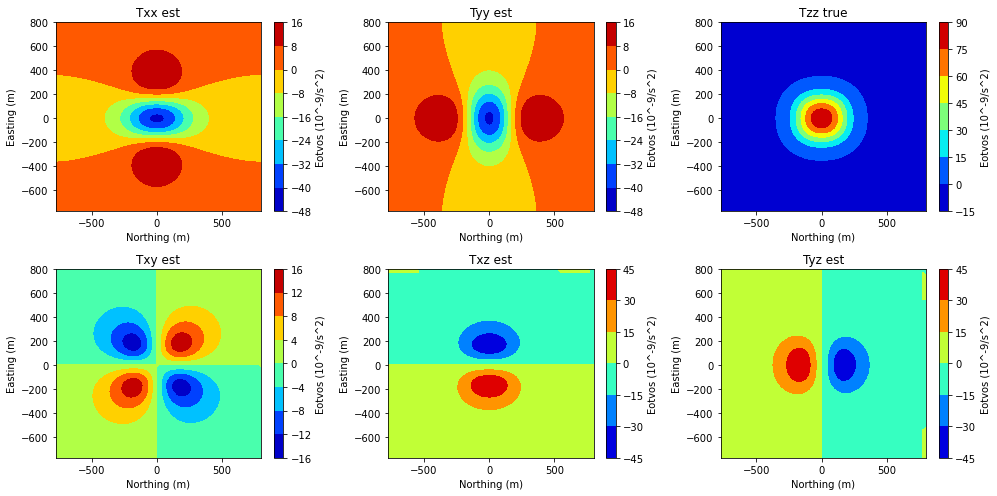

In [14]:
# plot data
plt.figure(figsize=(14,7))

plt.subplot(231)
gravplot(Txx_new,'Txx est')

plt.subplot(232)
gravplot(Tyy_new,'Tyy est')

plt.subplot(233)
gravplot(gtzz,'Tzz true')

plt.subplot(234)
gravplot(Txy_new,'Txy est')

plt.subplot(235)
gravplot(Txz_new,'Txz est')

plt.subplot(236)
gravplot(Tyz_new,'Tyz est')

plt.tight_layout()
plt.show()

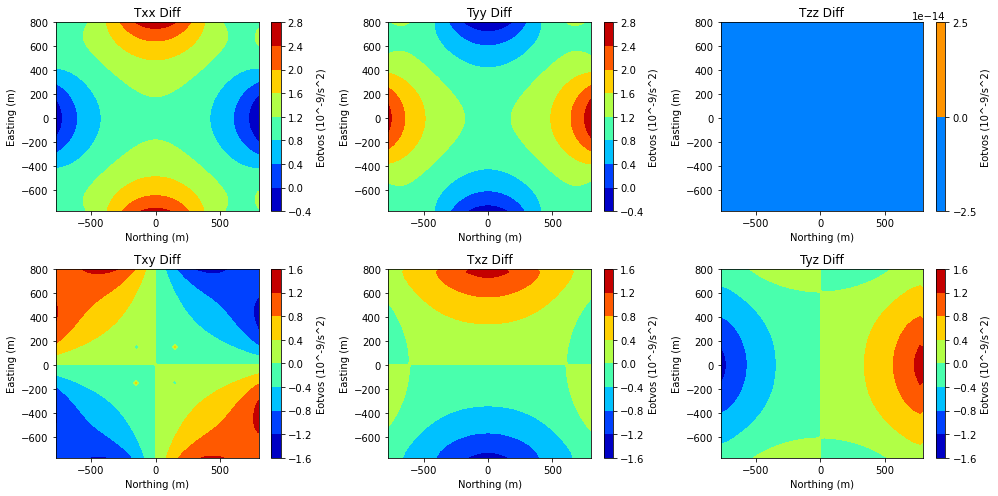

In [15]:
# plot differences
plt.figure(figsize=(14,7))

plt.subplot(231)
gravplot(Txx_new-gtxx,'Txx Diff')

plt.subplot(232)
gravplot(Tyy_new-gtyy,'Tyy Diff')

plt.subplot(233)
gravplot(gtzz-gtzz,'Tzz Diff')

plt.subplot(234)
gravplot(Txy_new-gtxy,'Txy Diff')

plt.subplot(235)
gravplot(Txz_new-gtxz,'Txz Diff')

plt.subplot(236)
gravplot(Tyz_new-gtyz,'Tyz Diff')

plt.tight_layout()
plt.show()

Some of the shapes and values are off in the estimation as demonstrated in the difference plots above. The max errors are 1.6 and 2.8 eotvos which are meaningful in the context of interpretation. However, the overall picture created by the estimations is very close the original data. Thus, the same general information about the shape, location, edges, etc. is still communicated. This is impressive and has application where you could pay a lot less to collect the vertical component and still get the other components in a meaningful way,

### Q2

In [16]:
# calculate upward continuation of Txx
Txx_new_up = gravup(northing,easting,gtxx)

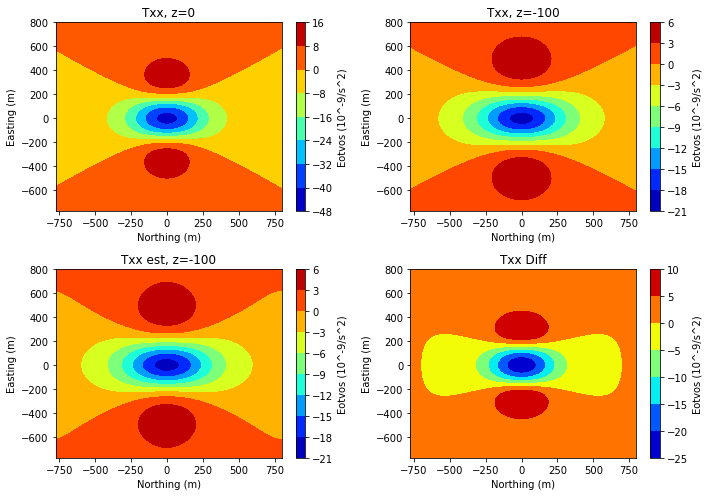

In [17]:
# plot upward continuation of Txx
plt.figure(figsize=(10,7))

plt.subplot(221)
gravplot(gtxx,'Txx, z=0')

plt.subplot(222)
gravplot(txx_up,'Txx, z=-100')

plt.subplot(223)
gravplot(Txx_new_up,'Txx est, z=-100')

plt.subplot(224)
gravplot(gtxx-Txx_new_up,'Txx Diff')

plt.tight_layout()
plt.show()

Similar to my interpretation on Q1, the shapes and values are not exactly correct. However, if we look at the min and max values of the true vs. calculated upward continuation, they are the same: ranging from -21 to 6. Thus, while there is some level of error to this method, there is also meaningful information contained which does not require you to collect data at a different observation height.

### Q3

In [18]:
# calculate vertical component in wavenumber domain
baz_new = convert_mag(northing, easting, bT)

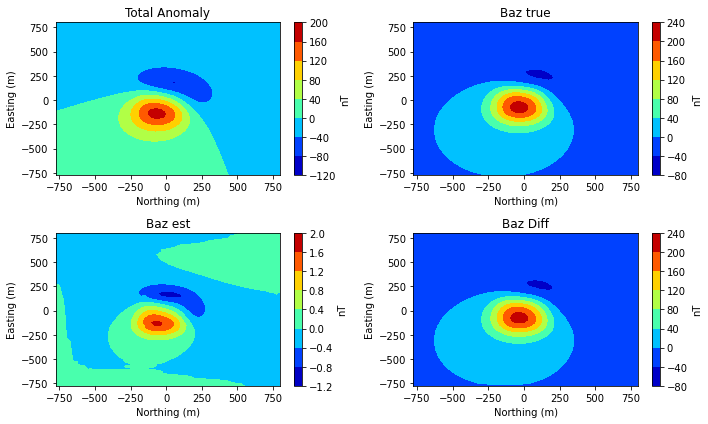

In [19]:
# plot total anomaly, calculated vertical component, actual vertical component, and difference
plt.figure(figsize=(10,6))

plt.subplot(221)
magplot(bT,'Total Anomaly')

plt.subplot(222)
magplot(baz,'Baz true')

plt.subplot(223)
magplot(baz_new,'Baz est')

plt.subplot(224)
magplot(baz-baz_new,'Baz Diff')

plt.tight_layout()
plt.show()

The gravity estimations using wavnumber-domain operations replicated the originals well. In comparison, the vertical component of the magnetic data is vastly different in terms of shape, values, and overall information. While the location of the large positive anomaly at the center, and the negative anomaly to the upper right are the same, the rest is quite different. First of all, the max and min values are 2 and -1.2 versus 240 and -80 with the original. Then, the actual shape/size of the anomalies and the background are vastly different. 

## Conclusion

Through this lab, an understanding of wavenumber-domain operations in geophysical data processing was gained. The experience of converting potential-field data components and performing upward continuation has highlighted the crucial role of Fourier transforms in geophysical explorations. The practical application of transfer functions in the wavenumber domain provided insights into how different data components relate and transform. Moreover, the comparative analysis between converted and directly calculated data components reinforced an understanding of the precision and limitations inherent in these methods. This exercise also brought to light the importance of careful error analysis in interpreting geophysical data. Overall, the lab has significantly enhanced comprehension of the theoretical underpinnings and practical applications in advanced gravity and magnetic exploration, laying a solid foundation for future explorations in these fields.